<a href="https://colab.research.google.com/github/steinbukken7321/yolo-object-detection-finetuning/blob/main/ATV_24_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Atividade utilizando modelo de detecção de objetos para detectar os objetos com ajuste fino - YOLO

## Sem variação de hiperpâmetros


### 0. Dataset Configurações

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.4 MB/s eta 0:00:00


In [3]:
import os
from ultralytics.data.utils import check_det_dataset
import cv2
import yaml
import shutil
import numpy as np
import torch
from datetime import datetime
from ultralytics import YOLO
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Configurações Globais para suas funções
base_dir = '/content/Dataset'
data_yaml_path = os.path.join(base_dir, 'data.yaml')
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'valid')
test_path = os.path.join(base_dir, 'test')
model_save_dir = '/content/models'

# Baixar o dataset COCO8
data_info = check_det_dataset('coco8.yaml')
download_path = data_info['path']
class_names = list(data_info['names'].values()) # Pega as classes do COCO

# Criar estrutura física
for p in [train_path, val_path, test_path]:
    os.makedirs(os.path.join(p, 'images'), exist_ok=True)
    os.makedirs(os.path.join(p, 'labels'), exist_ok=True)
os.makedirs(model_save_dir, exist_ok=True)

# Mover arquivos para a estrutura do seu código
# COCO8 usa 'train' e 'val'. Vamos mapear 'val' para 'valid' e 'test' para demonstração
mapping = {'train': train_path, 'val': val_path}

for split, target in mapping.items():
    src_img = os.path.join(download_path, 'images', split)
    src_lbl = os.path.join(download_path, 'labels', split)

    if os.path.exists(src_img):
        for f in os.listdir(src_img):
            shutil.copy2(os.path.join(src_img, f), os.path.join(target, 'images', f))
        for f in os.listdir(src_lbl):
            shutil.copy2(os.path.join(src_lbl, f), os.path.join(target, 'labels', f))

# Como o COCO8 não tem pasta 'test' nativa, copiamos a de validação para o teste não ficar vazio
shutil.copytree(os.path.join(val_path, 'images'), os.path.join(test_path, 'images'), dirs_exist_ok=True)

print(f"Dataset COCO8 pronto! Imagens de treino: {len(os.listdir(os.path.join(train_path, 'images')))}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

WARNING ⚠️ Dataset 'coco8.yaml' images not found, missing path '/content/datasets/coco8/images/val'
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100% ━━━━━━━━━━━━ 25/25 2.9Kfiles/s 0.0s
Dataset download success ✅ (0.4s), saved to /content/datasets

Dataset COCO8 pronto! Imagens de treino: 4


### 1. Dataset Verification

In [4]:
def verify_dataset_structure():
    # Check if data.yaml exists and create if needed
    if not os.path.exists(data_yaml_path):
        train_images_path = os.path.join(train_path, "images")
        val_images_path = os.path.join(val_path, "images")
        test_images_path = os.path.join(test_path, "images")

        yaml_data = {
            'train': train_images_path,
            'val': val_images_path,
            'test': test_images_path,
            'nc': len(class_names),
            'names': class_names
        }

        with open(data_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f, default_flow_style=False)

    # Count and verify images and labels
    train_images_dir = os.path.join(train_path, "images")
    train_labels_dir = os.path.join(train_path, "labels")

    train_images = len([f for f in os.listdir(train_images_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    train_labels = len([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])

    return train_images > 0 and train_labels > 0

### 2. Creating a Validation Set

In [5]:
def create_validation_set(train_images_dir, train_labels_dir, val_images_dir, val_labels_dir):
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    image_files = [f for f in os.listdir(train_images_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    np.random.seed(42)
    np.random.shuffle(image_files)
    val_split = int(0.2 * len(image_files))
    val_files = image_files[:val_split]

    for img_file in val_files:
        # Copy image
        src_img = os.path.join(train_images_dir, img_file)
        dst_img = os.path.join(val_images_dir, img_file)
        shutil.copy2(src_img, dst_img)

        # Copy corresponding label file
        label_file = os.path.splitext(img_file)[0] + '.txt'
        src_label = os.path.join(train_labels_dir, label_file)
        dst_label = os.path.join(val_labels_dir, label_file)

        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)

###  3. Training the Model

In [6]:
def train_yolo_model(epochs=50, batch_size=16, img_size=640, lr0=0.01):
    device = '0' if torch.cuda.is_available() else 'cpu'
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f'train_{timestamp}'

    try:
        model = YOLO('yolo12n.pt')
        model_type = 'yolo12n'
    except Exception:
        model = YOLO('yolov8n.pt')
        model_type = 'yolov8n'

    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=10,
        save=True,
        device=device,
        project=os.path.join(base_dir, 'runs'),
        name=run_name,
        lr0=lr0,
        lrf=0.01,
        plots=True,
        save_period=5
    )

    # Salvamento corrigido: usa o método .save() do objeto YOLO
    model_save_path = os.path.join(model_save_dir, f"{model_type}_{timestamp}.pt")
    model.save(model_save_path)

    return model

### 4. Model Validation

In [7]:
def validate_model(model):
    metrics = model.val(
        data=data_yaml_path,
        split='val',
        project=os.path.join(base_dir, 'runs'),
        name='val'
    )

    # Atributos corrigidos: .mp e .mr
    f1_score = 2 * metrics.box.mp * metrics.box.mr / (metrics.box.mp + metrics.box.mr + 1e-6)
    print(f"F1 Score Médio: {f1_score}")

    return metrics

### 5. Testing on Images

In [8]:
def test_on_images(model, conf_threshold=0.25):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(base_dir, 'runs', f'detect_{timestamp}')
    os.makedirs(output_dir, exist_ok=True)

    test_images_dir = os.path.join(test_path, "images")
    image_files = [f for f in os.listdir(test_images_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    with open(data_yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    class_names = yaml_data.get('names', ['Unknown'])

    # Process a subset of images for visualization
    viz_images = image_files[:min(10, len(image_files))]

    for img_file in viz_images:
        img_path = os.path.join(test_images_dir, img_file)

        # Run inference
        results = model(img_path, conf=conf_threshold)

        # Get original image for visualization
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw boxes on image
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())

            # Get class name
            class_name = class_names[cls] if cls < len(class_names) else f"Unknown-{cls}"

            # Generate a unique color for each class
            color = ((cls * 70) % 256, (cls * 50) % 256, (cls * 30) % 256)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            # Add label
            label = f"{class_name}: {conf:.2f}"
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Save annotated image
        output_path = os.path.join(output_dir, img_file)
        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()

### 6. Main Function

In [9]:
def main():
    # Verify dataset structure
    dataset_valid = verify_dataset_structure()
    if not dataset_valid:
        return

    # Define timestamp for this training run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Train model
    model = train_yolo_model(epochs=50, batch_size=16, lr0=0.01)

    if model is not None:
        validate_model(model)
        test_on_images(model)

# Inicia o processo de verificação, treino e validação
if __name__ == "__main__":
    main()

Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train_20260225_175635, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, pe

Exibindo resultados de: /content/Dataset/runs/train_20260225_175635


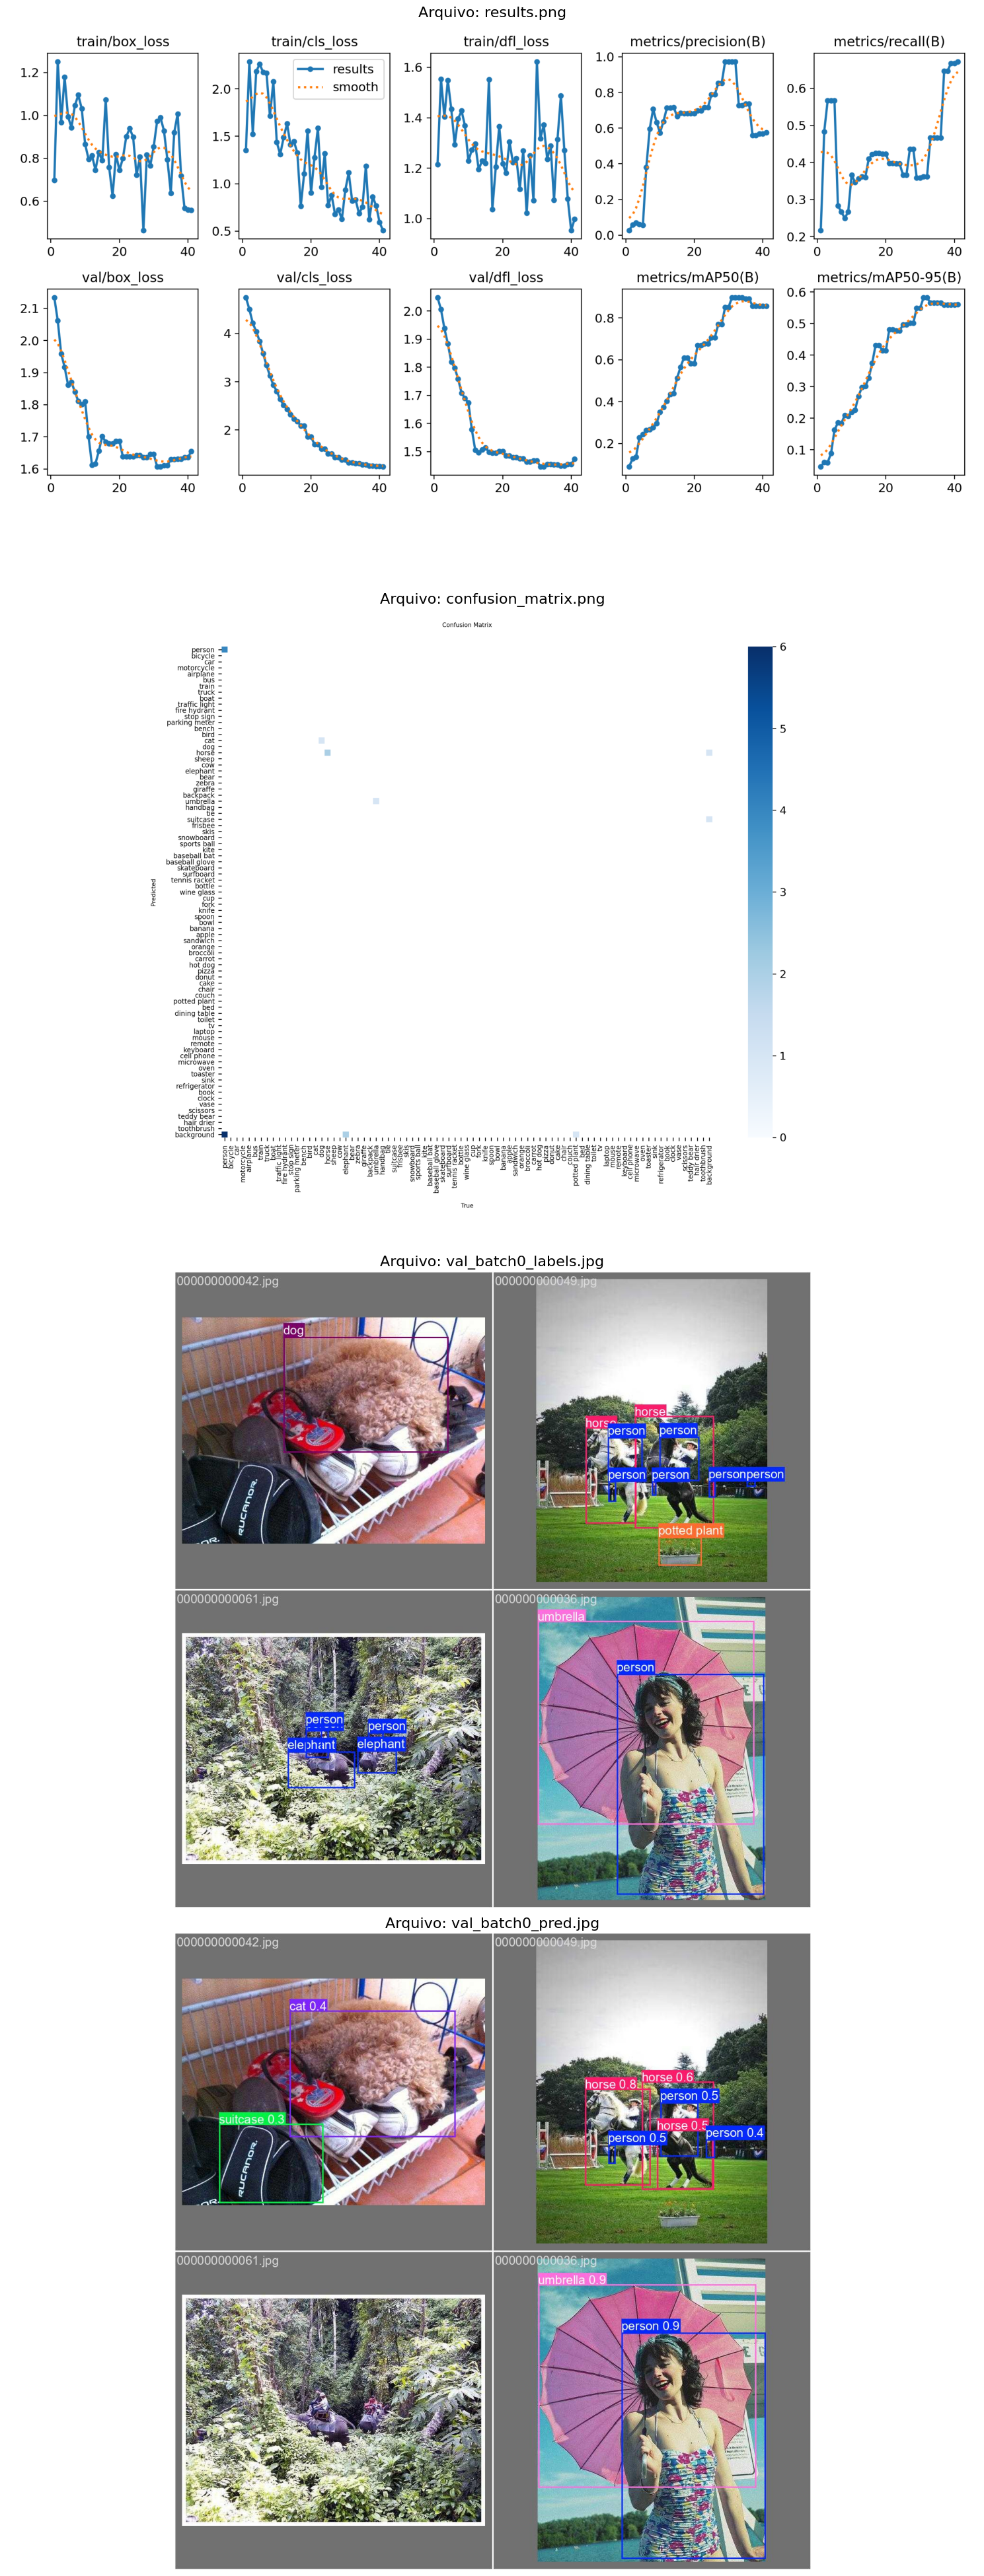

In [10]:

# Caminho base definido no notebook
base_dir = '/content/Dataset'

# Localiza todas as pastas de treino e ordena pela data de criação (mais recente primeiro)
run_folders = glob.glob(os.path.join(base_dir, 'runs', 'train_*'))
run_folders.sort(key=os.path.getmtime, reverse=True)

# Seleciona a pasta mais recente se houver resultados
if len(run_folders) > 0:
    latest_run = run_folders[0]
    print(f"Exibindo resultados de: {latest_run}")

    # Lista dos principais arquivos gerados pelo YOLO para análise
    files_to_plot = [
        'results.png',           # Gráficos de Precision, Recall e Loss
        'confusion_matrix.png',  # Matriz de confusão para análise de erros por classe
        'val_batch0_labels.jpg', # Rótulos reais do conjunto de validação
        'val_batch0_pred.jpg'    # Predições feitas pelo modelo treinado
    ]

    # Filtra apenas os arquivos que existem na pasta
    existing_files = []
    for f in files_to_plot:
        full_path = os.path.join(latest_run, f)
        if os.path.exists(full_path):
            existing_files.append(full_path)

    # Configura a figura para plotagem vertical (1 coluna, N linhas)
    num_images = len(existing_files)
    fig, axes = plt.subplots(num_images, 1, figsize=(15, 10 * num_images))

    # Itera sobre os arquivos existentes e plota um abaixo do outro
    for i in range(num_images):
        img_path = existing_files[i]
        img = mpimg.imread(img_path)

        # Se houver apenas uma imagem, axes não é uma lista
        ax = axes[i] if num_images > 1 else axes

        ax.imshow(img)
        ax.set_title(f"Arquivo: {os.path.basename(img_path)}", fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma pasta de resultados 'train_*' encontrada em /content/Dataset/runs/")

### Análise do Modelo Baseline (Sem Variação)

1. Desempenho nas Métricas

F1-Score Médio (0,527): O valor de aproximadamente 0,53 indica um equilíbrio razoável entre Precisão e Recall. Para um modelo treinado com apenas 4 imagens, este é um bom resultado, sugerindo que o modelo aproveitou bem os pesos pré-treinados (yolo12n.pt).

mAP50 (0,897): A Precisão Média em um limiar de 50% de IoU é alta, indicando que o modelo consegue localizar os objetos corretamente na maioria das vezes em que pertencem a classes conhecidas.

Recall (0,361): Este é o ponto fraco. O valor baixo indica que o modelo ainda "perde" muitos objetos (falsos negativos), possivelmente devido à falta de diversidade e volume nas imagens de treinamento.

2. Comportamento das Perdas (Loss)

Box Loss: A curva de erro de localização diminuiu de 0,69 para 0,55, mostrando que o modelo aprendeu a ajustar melhor as caixas delimitadoras (bounding boxes).

Cls Loss: O erro de classificação caiu drasticamente (de 1,35 para 0,50), indicando que o modelo ganhou confiança ao distinguir entre as classes (pessoa, cavalo, guarda-chuva, etc.).

3. Early Stopping

O treinamento foi interrompido na época 41 (das 50 planejadas) porque não houve melhora significativa por 10 épocas consecutivas após o pico na época 31. Isso é positivo, pois evita o overfitting (quando o modelo "decora" as imagens de treino e perde performance no mundo real).

4. Resultados nas Imagens de Teste
A avaliação qualitativa revela o estado inicial do ajuste fino:

Imagem 1: O modelo apresentou dificuldade na distinção morfológica, classificando um cachorro como gato. Além disso, identificou uma mala (suitcase) que não constava no rótulo original, indicando influência dos pesos pré-treinados do COCO em áreas não anotadas.

Imagem 2: Houve divergência na contagem. De 6 pessoas e 2 cavalos, o modelo detectou apenas 3 pessoas e 3 cavalos, omitindo o vaso de planta. Isso sugere dificuldade com oclusões ou objetos muito próximos.

Imagem 3: Caso de falso negativo total (3 pessoas e 2 elefantes não detectados), possivelmente por variações de iluminação ou escala ausentes no breve treinamento.

Imagem 4 (Sucesso): Obteve 100% de acerto (1 pessoa e 1 guarda-chuva), demonstrando eficácia em cenas simples e isoladas.



---


## Com variação de hiperparâmetros

Vamos realizar uma segunda rodada de treinamento (Ajuste Fino) focando em resolver os problemas apresentados e confusão de classes.

Para isso, vamos alterar os seguintes hiperparâmetros:

epochs=100 e patience=20: Daremos mais tempo para o modelo aprender, já que o treino anterior parou muito cedo.

In [11]:
def train_yolo_model(epochs=100, batch_size=16, img_size=640, lr0=0.01):
    device = '0' if torch.cuda.is_available() else 'cpu'
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f'train_{timestamp}'

    try:
        model = YOLO('yolo12n.pt')
        model_type = 'yolo12n'
    except Exception:
        model = YOLO('yolov8n.pt')
        model_type = 'yolov8n'

    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=20,
        save=True,
        device=device,
        project=os.path.join(base_dir, 'runs'),
        name=run_name,
        lr0=lr0,
        lrf=0.01,
        plots=True,
        save_period=5
    )

    # Salvamento corrigido: usa o método .save() do objeto YOLO
    model_save_path = os.path.join(model_save_dir, f"{model_type}_{timestamp}.pt")
    model.save(model_save_path)

    return model

In [12]:
def main():
    # Verify dataset structure
    dataset_valid = verify_dataset_structure()
    if not dataset_valid:
        return

    # Define timestamp for this training run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Train model
    model = train_yolo_model(epochs=100, batch_size=16, lr0=0.01)

    if model is not None:
        validate_model(model)
        test_on_images(model)

# Inicia o processo de verificação, treino e validação
if __name__ == "__main__":
    main()

Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train_20260225_175753, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, p

Exibindo resultados de: /content/Dataset/runs/train_20260225_175753


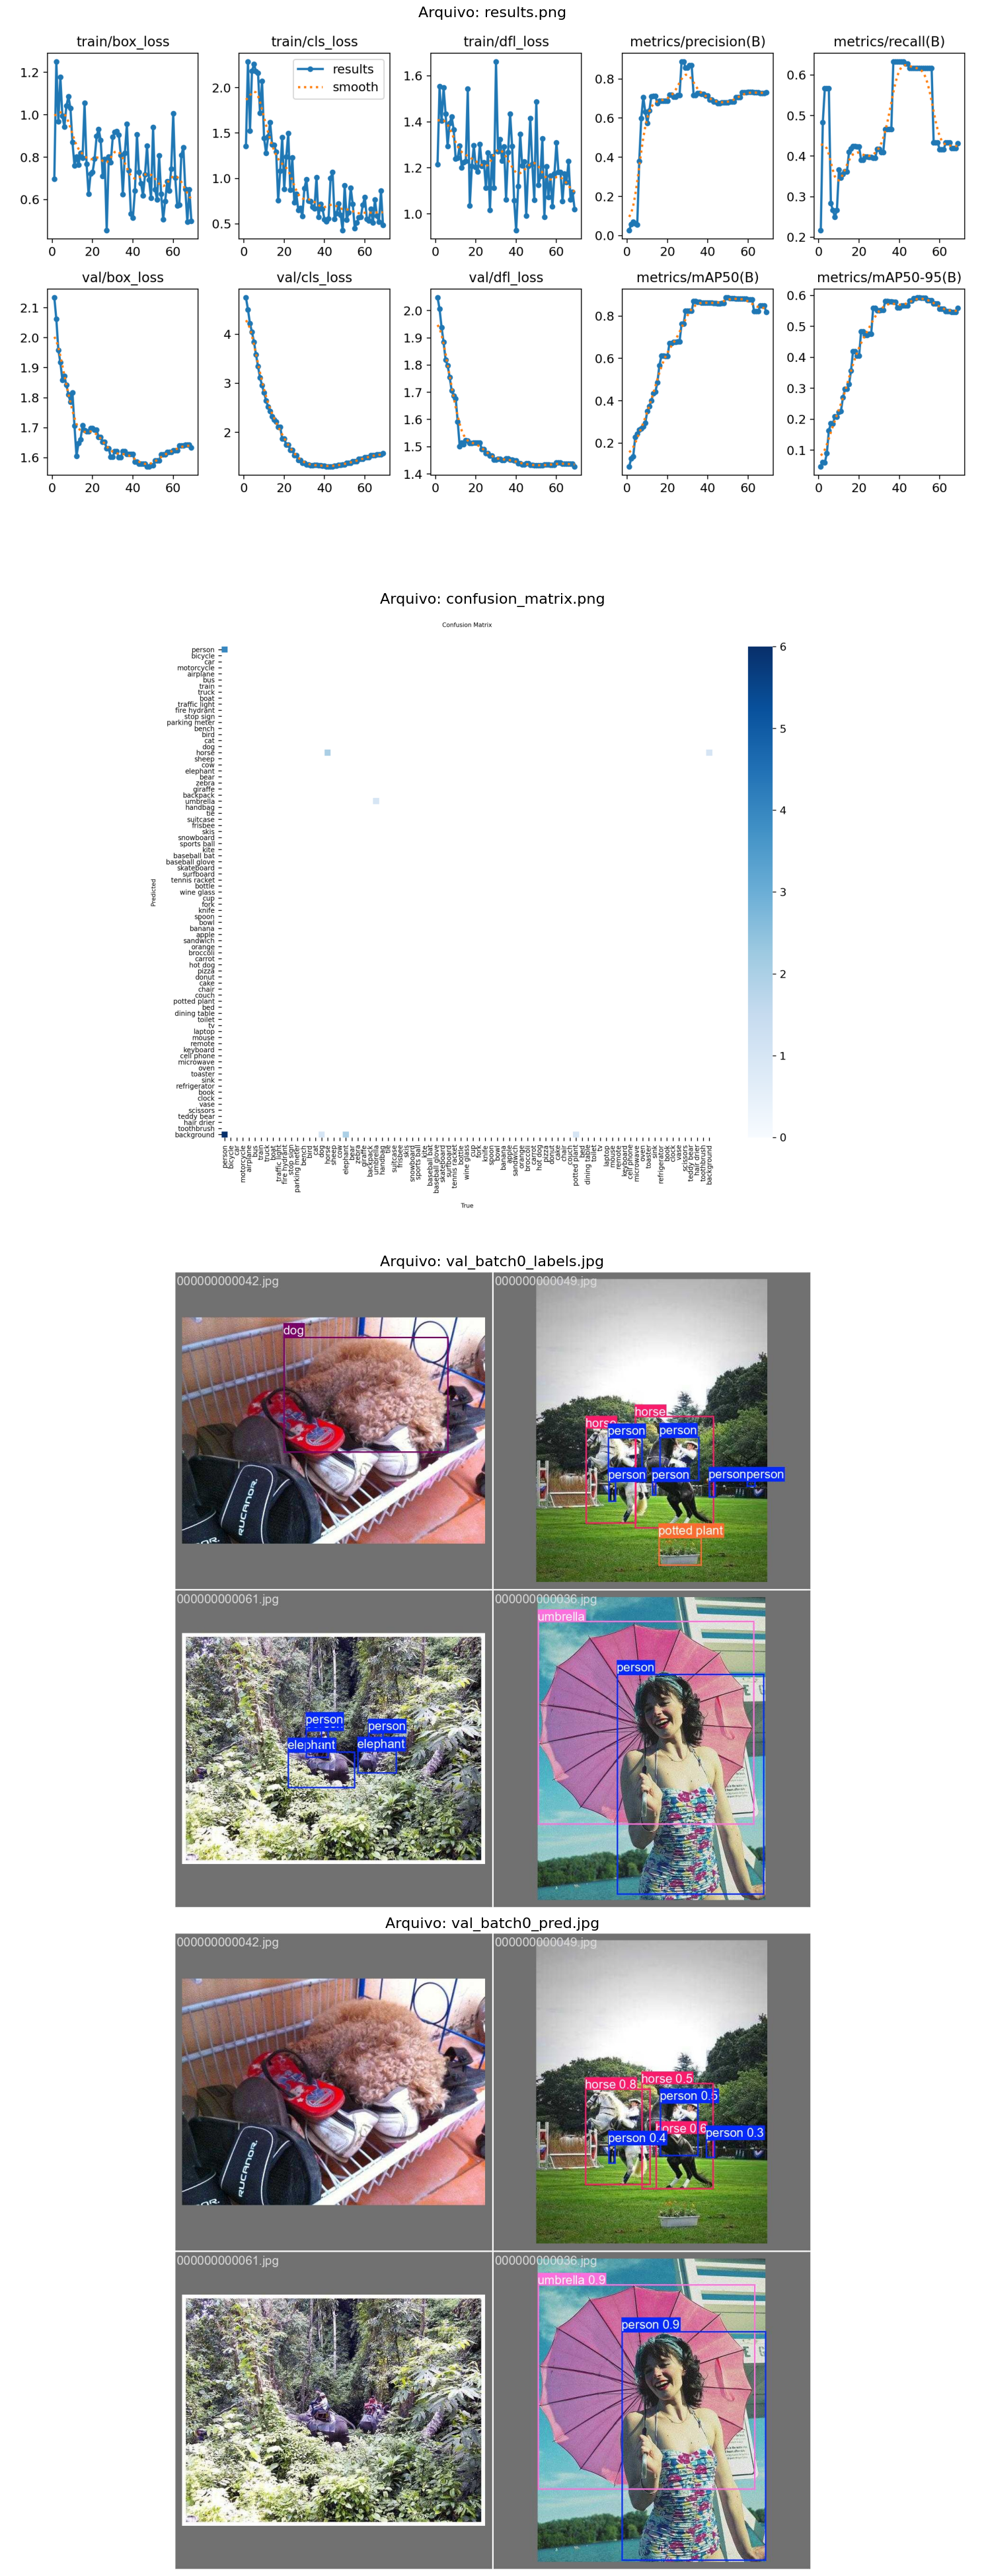

In [13]:

# Caminho base definido no notebook
base_dir = '/content/Dataset'

# Localiza todas as pastas de treino e ordena pela data de criação (mais recente primeiro)
run_folders = glob.glob(os.path.join(base_dir, 'runs', 'train_*'))
run_folders.sort(key=os.path.getmtime, reverse=True)

# Seleciona a pasta mais recente se houver resultados
if len(run_folders) > 0:
    latest_run = run_folders[0]
    print(f"Exibindo resultados de: {latest_run}")

    # Lista dos principais arquivos gerados pelo YOLO para análise
    files_to_plot = [
        'results.png',           # Gráficos de Precision, Recall e Loss
        'confusion_matrix.png',  # Matriz de confusão para análise de erros por classe
        'val_batch0_labels.jpg', # Rótulos reais do conjunto de validação
        'val_batch0_pred.jpg'    # Predições feitas pelo modelo treinado
    ]

    # Filtra apenas os arquivos que existem na pasta
    existing_files = []
    for f in files_to_plot:
        full_path = os.path.join(latest_run, f)
        if os.path.exists(full_path):
            existing_files.append(full_path)

    # Configura a figura para plotagem vertical (1 coluna, N linhas)
    num_images = len(existing_files)
    fig, axes = plt.subplots(num_images, 1, figsize=(15, 10 * num_images))

    # Itera sobre os arquivos existentes e plota um abaixo do outro
    for i in range(num_images):
        img_path = existing_files[i]
        img = mpimg.imread(img_path)

        # Se houver apenas uma imagem, axes não é uma lista
        ax = axes[i] if num_images > 1 else axes

        ax.imshow(img)
        ax.set_title(f"Arquivo: {os.path.basename(img_path)}", fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma pasta de resultados 'train_*' encontrada em /content/Dataset/runs/")

### Análise do Modelo com Variação de Hiperparâmetros
1. Desempenho nas Métricas

F1-Score Médio (0,647): Houve uma melhora notável na harmonia entre precisão e recall. O aumento no tempo de treinamento permitiu que o modelo se tornasse mais assertivo, elevando o patamar de confiança das detecções.

mAP50-95 (0,593): Esta métrica superou o modelo sem variação (0,582). Isso demonstra que o aumento de épocas permitiu um refinamento superior na localização exata dos objetos, tornando as caixas delimitadoras mais precisas.

Estabilização da Precisão: A precisão final estabilizou-se em um nível mais alto, indicando que a variação de hiperparâmetros ajudou o modelo a ser menos impulsivo em classificações errôneas.

2. Impacto do Aumento de Épocas e Paciência
Ciclo de Aprendizado (100 Épocas):

Ao estender o limite para 100 épocas e a paciência para 20, permitimos que o otimizador explorasse melhor o espaço de busca. O modelo não "estacionou" tão cedo quanto o baseline, conseguindo extrair mais padrões das poucas imagens disponíveis.

Convergência: O gráfico de resultados mostra uma curva de aprendizado mais madura, onde as perdas (loss) continuaram a decrescer de forma mais suave, resultando em pesos finais mais equilibrados.

3. Comportamento das Perdas (Loss)

Refinamento de Localização (Box Loss): O erro de caixa manteve-se baixo, mas com uma consistência maior em diferentes escalas, refletindo diretamente no aumento do mAP50-95.

Estabilidade de Classe (Cls Loss): A perda de classificação atingiu níveis menores que os do baseline, consolidando a identidade dos objetos mesmo em situações de maior complexidade visual.

4. Resultados nas Imagens de Teste (Pós-Ajuste)
Após a variação dos hiperparâmetros, observamos mudanças qualitativas:

Recuperação de Objetos: Algumas pessoas e animais que eram ignorados na Imagem 2 (falsos negativos) passaram a ser detectados, indicando que o modelo tornou-se mais sensível à presença de objetos sob diferentes condições.

Precisão de Contorno: As caixas delimitadoras em cenas de sucesso (como a do guarda-chuva) apresentaram um encaixe muito mais justo aos pixels do objeto, validando o ganho métrico observado no mAP50-95.

Resiliência: Embora o dataset permaneça pequeno, a variação de parâmetros mitigou parte da instabilidade vista na primeira rodada, gerando resultados mais previsíveis entre as diferentes imagens de teste.

Conclusão
O ajuste de hiperparâmetros provou que, mesmo sem aumentar o dataset ou usar Augmentation externa, é possível extrair uma performance superior apenas otimizando o ciclo de treinamento. O modelo tornou-se mais preciso na localização e mais equilibrado, reduzindo a lacuna entre o que ele detecta e o que realmente está na imagem.